In [27]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from scripts import END_DATE
from scripts.analysis import data, plot

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import silhouette_score

plot.init_matplotlib()

W, H = 6, 2.5

In [ ]:
repos, stars = data.get_fake_star_repos(), data.get_fake_stars_by_month()
repos_with_campaign = data.get_repos_with_campaign()
repo_campaign_months = set(zip(stars[stars.anomaly].repo, stars[stars.anomaly].month))

In [ ]:
# bean counting
print("# repos with suspected fake stars:", len(repos))
print(
    "# suspected fake stars:",
    sum(stars.n_stars_fake),
    ", # low activity, ",
    sum(stars.n_stars_low_activity),
    ", # clustered, ",
    sum(stars.n_stars_clustered),
)
print("# repos with suspected fake star campaigns:", len(repos_with_campaign))
print(
    "# suspected fake stars in those campaigns:",
    sum(stars[stars.repo.isin(repos_with_campaign)].n_stars_fake),
)

low_activity_actors = data.get_unique_actors("low_activity")
clustered_actors = data.get_unique_actors("clustered")
print(
    "# actors in suspected fake stars:",
    len(clustered_actors | low_activity_actors),
)

low_activity_actors_in_campaign = data.get_unique_actors_in_campaign("low_activity")
print("# low activity stars in campaign:", len(low_activity_actors_in_campaign))

clustered_actors_in_campaign = data.get_unique_actors_in_campaign("clustered")
print("# clustered actors in campaign:", len(clustered_actors_in_campaign))
print(
    "# actors in suspected fake star campaigns:",
    len(clustered_actors_in_campaign | low_activity_actors_in_campaign),
)

# repos with suspected fake stars: 26254
# suspected fake stars: 5999002.0 , # low activity,  1066934.0 , # clustered,  4932068.0
# repos with suspected fake star campaigns: 18617
# suspected fake stars in those campaigns: 3807118.0
# actors in suspected fake stars: 1501957
# low activity stars in campaign: 96309
# clustered actors in campaign: 206355
# actors in suspected fake star campaigns: 301096


In [6]:
# How many random sample repos and actors are already polluted?
sample_repo_events = pd.read_csv(f"data/{END_DATE}/sample_repo_events.csv")
sample_actor_events = pd.read_csv(f"data/{END_DATE}/sample_actor_events.csv")
print(
    f"# polluted repos in sample_repo_events: "
    f"{len(set(sample_repo_events.repo) & set(repos.repo_name))} "
    f"out of {len(sample_repo_events.repo)}",
)
print(
    f"# polluted actors in sample_actor_events: "
    f"{len(set(sample_actor_events.actor) & (clustered_actors | low_activity_actors))} "
    f"out of {len(sample_actor_events.actor)}",
)
print(
    f"After filtering: "
    f"{repo_events[repo_events.group == "Samples"].repo.nunique()} sample repos, "
    f"{actor_events[actor_events.group == "Samples"].actor.nunique()} sample actors"
)

# polluted repos in sample_repo_events: 422 out of 10000
# polluted actors in sample_actor_events: 957 out of 10000
After filtering: 9578 sample repos, 9043 sample actors


In [7]:
# face validity check: how many of the repos and actors are deleted?
deleted = repos.repo_id.isnull()
low_act = repos.n_stars_low_activity > 0
clustered = repos.n_stars_clustered > 0
campaign = repos.repo_name.isin(repos_with_campaign)
sample_repo_ids = pd.read_csv(f"data/{END_DATE}/sample_repo_ids.csv")
print(
    f"Baseline % deletion: {len(sample_repo_ids[sample_repo_ids.id.isnull()]) / len(repos) * 100:.2f}%"
)
print(
    f"% deleted in repos with fake stars: {len(repos[deleted]) / len(repos) * 100:.2f}\n"
    f"% deleted in low activity repos: {len(repos[deleted & low_act]) / len(repos[low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos: {len(repos[deleted & clustered]) / len(repos[clustered]) * 100:.2f}\n"
)
print(
    f"% deleted in repos with fake star campaigns: {len(repos[deleted & campaign]) / len(repos[campaign]) * 100:.2f}\n"
    f"% deleted in low activity repos with campaign: {len(repos[deleted & campaign & low_act]) / len(repos[campaign & low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos with campaign: {len(repos[deleted & campaign & clustered]) / len(repos[campaign & clustered]) * 100:.2f}\n"
)

fake_user_info = pd.read_csv(f"data/{END_DATE}/fake_user_info.csv")
sample_user_info = pd.read_csv(f"data/{END_DATE}/sample_user_info.csv")

deleted = fake_user_info.error.notnull()
low_act = fake_user_info.actor.isin(low_activity_actors)
clustered = fake_user_info.actor.isin(clustered_actors)
campaign = fake_user_info.actor.isin(
    clustered_actors_in_campaign | low_activity_actors_in_campaign
)
print(
    f"Baseline % deletion: {len(sample_user_info[sample_user_info.error.notnull()]) / len(repos) * 100:.2f}%"
)
print(
    f"% deleted in repos with fake stars: {len(fake_user_info[deleted]) / len(fake_user_info) * 100:.2f}\n"
    f"% deleted in low activity repos: {len(fake_user_info[deleted & low_act]) / len(fake_user_info[low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos: {len(fake_user_info[deleted & clustered]) / len(fake_user_info[clustered]) * 100:.2f}\n"
)
print(
    f"% deleted in repos with fake star campaigns: {len(fake_user_info[deleted & campaign]) / len(fake_user_info[campaign]) * 100:.2f}\n"
    f"% deleted in low activity repos with campaign: {len(fake_user_info[deleted & campaign & low_act]) / len(fake_user_info[campaign & low_act]) * 100:.2f}\n"
    f"% deleted in clustered repos with campaign: {len(fake_user_info[deleted & campaign & clustered]) / len(fake_user_info[campaign & clustered]) * 100:.2f}\n"
)

Baseline % deletion: 5.03%
% deleted in repos with fake stars: 70.05
% deleted in low activity repos: 14.38
% deleted in clustered repos: 82.03

% deleted in repos with fake star campaigns: 90.42
% deleted in low activity repos with campaign: 79.36
% deleted in clustered repos with campaign: 90.70

Baseline % deletion: 3.54%
% deleted in repos with fake stars: 18.77
% deleted in low activity repos: 19.19
% deleted in clustered repos: 23.03

% deleted in repos with fake star campaigns: 57.07
% deleted in low activity repos with campaign: 72.29
% deleted in clustered repos with campaign: 48.83



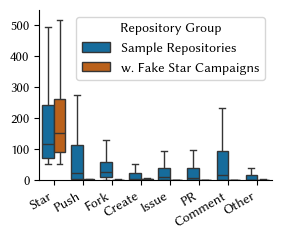

In [8]:
fig, ax = plt.subplots(figsize=(W / 2, H))
sns.boxplot(
    x="event",
    y="count",
    data=repo_event_counts[
        repo_event_counts.repo.isin(repos_with_campaign) | (repo_event_counts.group == "Samples")
    ],
    hue="group",
    hue_order=["Samples", "Suspected Fakes"],
    order=plot.EVENT_ORDER,
    palette=["C0", "C2"],
    showfliers=False,
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("")
handles, labels = ax.get_legend_handles_labels()
ax.legend(title="Repository Group", handles=handles, labels=["Sample Repositories", "w. Fake Star Campaigns"])
ax.set_ylim(0, 550)
#ax.set_yscale("log")
# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.autofmt_xdate()
fig.savefig("plots/repo-events.pdf", bbox_inches="tight", dpi=300)

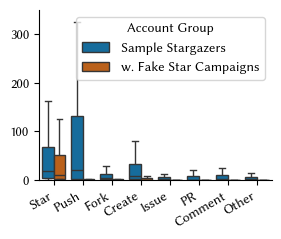

In [9]:
fig, ax = plt.subplots(figsize=(W/2, H))
sns.boxplot(
    x="event",
    y="count",
    data=actor_event_counts[
        actor_event_counts.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
        | (actor_event_counts.group == "Samples")
    ],
    hue="group",
    order=plot.EVENT_ORDER,
    hue_order=["Samples", "Suspected Fakes"],
    palette=["C0", "C2"],
    # errorbar="sd",
    showfliers=False,
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("")
handles, labels = ax.get_legend_handles_labels()
ax.legend(title="Account Group", handles=handles, labels=["Sample Stargazers", "w. Fake Star Campaigns"])
ax.set_ylim(0, 350)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.autofmt_xdate()
fig.savefig("plots/actor-events.pdf", bbox_inches="tight", dpi=300)

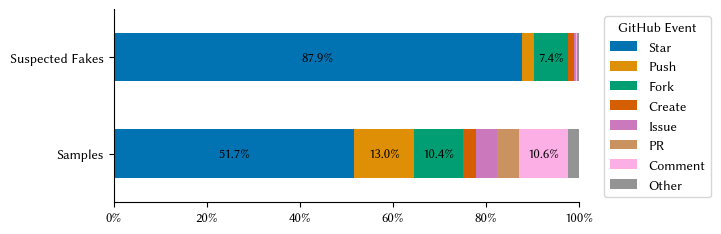

In [10]:
fig, ax = plt.subplots(figsize=(W, H))
data = (
    repo_event_percentages[
        repo_event_percentages.repo.isin(repos_with_campaign)
        | (repo_event_percentages.group == "Samples")
    ]
    .groupby(["group", "event"])["percentage"]
    .mean()
    .unstack()
)
data = data[plot.EVENT_ORDER]
data.plot.barh(stacked=True, ax=ax, color=sns.color_palette("colorblind"))
for p in ax.patches:
    if p.get_width() > 0.05:
        ax.annotate(
            f"{p.get_width() * 100:.1f}%",
            (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() / 2 - 0.005),
            ha="center",
            va="center",
        )
ax.legend(title="GitHub Event", bbox_to_anchor=(1.3, 1))
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.set_xlim(0, 1)
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig("plots/repo-event-percentage.pdf", bbox_inches="tight")

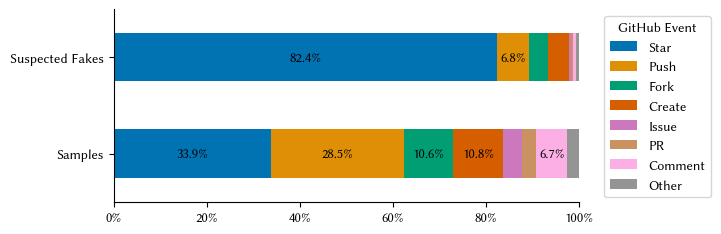

In [11]:
fig, ax = plt.subplots(figsize=(W, 2.5))
data = (
    actor_event_percentages[
        actor_event_percentages.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
        | (actor_event_percentages.group == "Samples")
    ]
    .groupby(["group", "event"])["percentage"]
    .mean()
    .unstack()
)
data = data[plot.EVENT_ORDER]
data.plot.barh(stacked=True, ax=ax, color=sns.color_palette("colorblind"))
for p in ax.patches:
    if p.get_width() > 0.05:
        ax.annotate(
            f"{p.get_width() * 100:.1f}%",
            (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() / 2 - 0.005),
            ha="center",
            va="center",
        )
ax.legend(title="GitHub Event", loc="upper right", bbox_to_anchor=(1.3, 1))
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.set_xlim(0, 1)
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig("plots/actor-event-percentage.pdf", bbox_inches="tight")

In [ ]:
repo_events = data.get_events_with_samples("repo")
actor_events = data.get_events_with_samples("actor")
repo_events.event = repo_events.event.apply(plot.shorten_gharchive_event)
actor_events.event = actor_events.event.apply(plot.shorten_gharchive_event)
repo_event_percentages = (
    repo_events.groupby(["repo", "event", "group"])["percentage"]
    .sum()
    .reset_index()
    .sort_values("repo")
)
actor_event_percentages = (
    actor_events.groupby(["actor", "event", "group"])["percentage"]
    .sum()
    .reset_index()
    .sort_values("actor")
)

In [41]:
X_fake_repo = (repo_event_percentages[
        (repo_event_percentages.group == "Suspected Fakes")
        & repo_event_percentages.repo.isin(repos_with_campaign)
    ]
    .drop(columns="group")
    .pivot(columns="event", index="repo", values="percentage")
    )
X_fake_actor = (
    actor_event_percentages[
        (actor_event_percentages.group == "Suspected Fakes")
        & actor_event_percentages.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
    ]
    .drop(columns="group")
    .pivot(columns="event", index="actor", values="percentage")
)

for k in range(2, 8):
    kmeans_model = KMeans(n_clusters=k, random_state=42).fit(StandardScaler().fit_transform(X_fake_repo))
    labels = kmeans_model.labels_
    score = silhouette_score(X_fake_repo, labels, metric="euclidean")
    print(k, score)

2 0.659277324680839
3 0.8353997986535988
4 0.8221636546574604
5 0.8449764914120971
6 0.8184614100832677
7 0.8266936216761867
Index(['Comment', 'Create', 'Fork', 'Issue', 'Other', 'PR', 'Push', 'Star'], dtype='object', name='event')
1 1391 [0.002525820707615857, 0.021017500895058345, 0.006926611170979703, 0.0020874187139583687, 0.001066266799848283, 0.0007935798629441591, 0.010021939774105957, 0.955560862075489]
0 264 [0.027885483155874444, 0.17938866283530627, 0.0254671490216498, 0.015706625869855467, 0.03250983354867592, 0.029154717467177203, 0.40440214556850024, 0.2854853825329606]
2 134 [0.0023511422079341457, 0.017550762268755935, 0.43739024976768137, 0.0050713500157012, 0.003421492960696043, 5.3187140018324616e-05, 0.010774821190187063, 0.523386994449026]


In [42]:
kmeans_model = KMeans(n_clusters=3, random_state=42).fit(X_fake_actor)
centers = defaultdict(list)
for i, cluster in enumerate(kmeans_model.labels_):
    centers.setdefault(cluster, []).append(X_fake_repo.to_numpy()[i])
centers = {k: (len(v), list(np.mean(v, axis=0))) for k, v in centers.items()}
print(X_fake_repo.columns)
for k, (n, center) in centers.items():
    print(k, n, center)

Index(['Comment', 'Create', 'Fork', 'Issue', 'Other', 'PR', 'Push', 'Star'], dtype='object', name='event')
1 1391 [0.0028034217625202244, 0.011783044800738489, 0.052682511784732544, 0.0015073724800185576, 0.0033522701894616305, 0.001224888355693592, 0.016577129440776384, 0.910069361186059]
0 264 [0.0007554695217118224, 0.011333620636473968, 0.05428565717869033, 0.0003754327245361126, 0.0031627964777820577, 0.0007406064792067233, 0.011376045191884019, 0.9179703717897149]
2 134 [0.0001402463633599678, 0.011707022538989496, 0.04009378116413354, 0.0001483437771995636, 0.003707307478551282, 0.0013687023398292382, 0.012014098342548525, 0.9308204979953881]


In [37]:
for k in range(2, 8):
    speatral_model = SpectralClustering(
        n_clusters=k,
        random_state=42,
        assign_labels="kmeans",
        affinity="nearest_neighbors",
    ).fit(X_fake_actor)

    labels = speatral_model.labels_
    score = silhouette_score(StandardScaler().fit_transform(X_fake_actor), labels, metric="euclidean")

    kmeans_model = KMeans(n_clusters=k, random_state=42).fit(X_fake_actor)
    labels = kmeans_model.labels_
    score2 = silhouette_score(StandardScaler().fit_transform(X_fake_actor), labels, metric="euclidean")

    print(k, score, score2)

2 0.34936317619937474 0.6382992290796918
3 0.379757773134572 0.6787379393964628
4 0.4245044400144348 0.6747176831385725
5 0.45993480570658685 0.641335930887113
6 0.4799666742993091 0.6174930245325445
7 0.4880887989312275 0.6195576946469152


In [44]:
kmeans_model = KMeans(n_clusters=3, random_state=42).fit(X_fake_actor)
centers = defaultdict(list)
for i, cluster in enumerate(kmeans_model.labels_):
    centers.setdefault(cluster, []).append(X_fake_actor.to_numpy()[i])
centers = {k: (len(v), list(np.mean(v, axis=0))) for k, v in centers.items()}
print(X_fake_actor.columns)
for k, (n, center) in centers.items():
    print(k, n, [f"{c:.4f}" for c in center])

Index(['Comment', 'Create', 'Fork', 'Issue', 'Other', 'PR', 'Push', 'Star'], dtype='object', name='event')
1 1391 ['0.0025', '0.0210', '0.0069', '0.0021', '0.0011', '0.0008', '0.0100', '0.9556']
0 264 ['0.0279', '0.1794', '0.0255', '0.0157', '0.0325', '0.0292', '0.4044', '0.2855']
2 134 ['0.0024', '0.0176', '0.4374', '0.0051', '0.0034', '0.0001', '0.0108', '0.5234']


In [ ]:
X_sample_repo = StandardScaler().fit_transform(
    repo_event_percentages[repo_event_percentages.group == "Samples"]
    .drop(columns="group")
    .pivot(columns="event", index="repo", values="percentage")
    .reset_index()
)
X_sample_actor = StandardScaler().fit_transform(
    actor_event_percentages[actor_event_percentages.group == "Samples"]
    .drop(columns="group")
    .pivot(columns="event", index="actor", values="percentage")
    .reset_index()
)

Y_repos, Y_actors = {}, {}
perplexities = [30, 50, 100]
for perplexity in perplexities:
    tSNE = TSNE(n_components=2, perplexity=perplexity, random_state=114514)
    Y_repos[perplexity] = tSNE.fit_transform(
        StandardScaler().fit_transform(
            np.concatenate(
                [
                    X_fake_repo.set_index("repo").to_numpy(),
                    X_sample_repo.set_index("repo").to_numpy(),
                ]
            )
        )
    )
    Y_actors[perplexity] = tSNE.fit_transform(
        StandardScaler().fit_transform(
            np.concatenate(
                [
                    X_fake_actor.set_index("actor").to_numpy(),
                    X_sample_actor.set_index("actor").to_numpy(),
                ]
            )
        )
    )

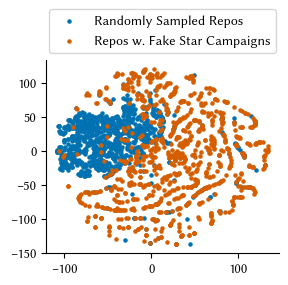

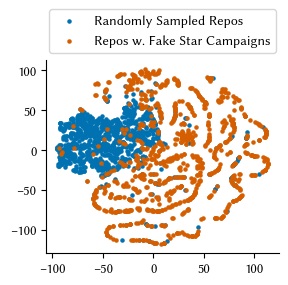

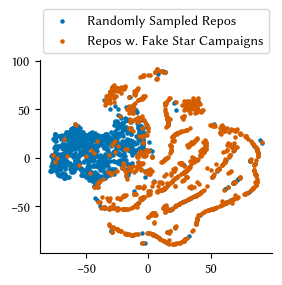

In [ ]:
low_activity_ids = list(
    X_fake_actor[X_fake_actor.actor.isin(low_activity_actors)].index
)
clustered_ids = list(X_fake_actor[X_fake_actor.actor.isin(clustered_actors)].index)
sample_fakes = random.sample(range(0, len(X_fake_repo)), 1000)
sample_reals = random.sample(
    range(len(X_fake_repo), len(X_fake_repo) + len(X_sample_repo)), 1000
)

for perplexity in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ax.scatter(
        Y_repos[perplexity][sample_reals, 0],
        Y_repos[perplexity][sample_reals, 1],
        c="C0",
        s=5,
        label="Randomly Sampled Repos",
    )
    ax.scatter(
        Y_repos[perplexity][sample_fakes, 0],
        Y_repos[perplexity][sample_fakes, 1],
        c="C2",
        s=5,
        label="Repos w. Fake Star Campaigns",
    )
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3)),
    # ax.set_title(f"t-SNE (perplexity={perplexity})")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.savefig(f"plots/tsne-repos-{perplexity}.pdf", bbox_inches="tight", dpi=300)

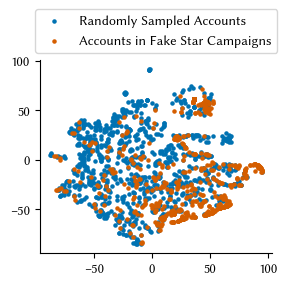

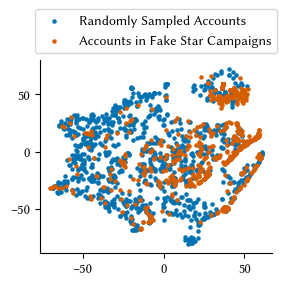

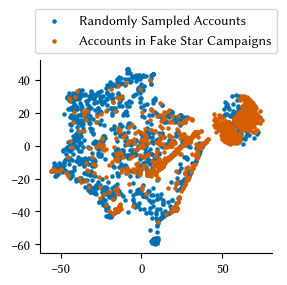

In [ ]:
low_activity_ids = list(
    X_fake_actor[X_fake_actor.actor.isin(low_activity_actors)].index
)
clustered_ids = list(X_fake_actor[X_fake_actor.actor.isin(clustered_actors)].index)
sample_fakes = random.sample(range(0, len(X_fake_actor)), 1000)
sample_reals = random.sample(
    range(len(X_fake_actor), len(X_fake_actor) + len(X_sample_actor)), 1000
)

for perplexity in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ax.scatter(
        Y_actors[perplexity][sample_reals, 0],
        Y_actors[perplexity][sample_reals, 1],
        c="C0",
        s=5,
        label="Randomly Sampled Accounts",
    )
    ax.scatter(
        Y_actors[perplexity][sample_fakes, 0],
        Y_actors[perplexity][sample_fakes, 1],
        c="C2",
        s=5,
        label="Accounts in Fake Star Campaigns",
    )
    """
    ax.scatter(
        Y_actors[perplexity][low_activity_ids, 0],
        Y_actors[perplexity][low_activity_ids, 1],
        c="C2",
        s=5,
        alpha=1.0,
        # edgecolors="black",
        label="Stargazers with the Low Activity Heusristic",
    )
    ax.scatter(
        Y_actors[perplexity][clustered_ids, 0],
        Y_actors[perplexity][clustered_ids, 1],
        c="C3",
        s=5,
        alpha=1.0,
        # edgecolors="black",
        label="Stargazers with the Clustering Heusristic",
    )"""
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))
    #ax.set_title(f"t-SNE (perplexity={perplexity})")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.savefig(f"plots/tsne-actors-{perplexity}.pdf", bbox_inches="tight", dpi=300)